# Lab 10 - Language Modeling with Transformers
In this lab, your task is to build a character-level language model with LSTM layer.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd "/content/drive/MyDrive/UCCD3074_Labs/UCCD3074_Lab10"

In [ ]:
import os
import math
import torch
import torch.nn as nn
from torch.nn import functional as F

import time

In [ ]:
torch.manual_seed(1234)
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
if not os.path.exists('input.txt'):
    !wget 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

---
# Preprocessing

Read the dataset into the string `raw_data`.

In [ ]:
with open('./input.txt', 'r', encoding='utf-8') as f:
    raw_data = f.read()

Create the vocabulary

In [ ]:
vocab = sorted(list(set(raw_data)))
vocab_size=len(vocab)
print('vocab_size:', vocab_size)

In [ ]:
stoi = {ch:i for i, ch in enumerate(vocab)}
itos = {i:ch for i, ch in enumerate(vocab)}

In [ ]:
encode_text = lambda s : [stoi[c] for c in s]    # encode: take a string, output a list of integers
decode_text = lambda l : ''.join([itos[i] for i in l])

In [ ]:
data = torch.tensor(encode_text(raw_data), dtype=torch.long)

The function `get_batch` randomly sample a block of text as input `x`. The label `y` is the block of text shifted by 1 position of `x`.

In [ ]:
def get_batch(batch_size, block_size):
    ix   = torch.randint(len(data) - block_size, (batch_size,))
    x    = torch.stack([data[i:i+block_size] for i in ix])
    y    = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

---
# Character-level language model with Transformer model

Now, let's build the character-level language model with LSTM. The network `LMNet` has the following layers:

|Layer| Configuration | Shape |
|---|---|---|
| Input | - | `(B, T)`|
|Token Embedding | num_embedding = vocab_size, <br> embedding_dim = d_model | `(B, T, d_model)`|
|Position Embedding | d_model = d_model | `(B, T, d_model)`|
|TransformerEncoder | d_model (default: 512), <br> nhead (default = 6), <br> dim_feedforward, <br> batch_first (default: False) | `(B, T, d_model)` |
| fc | in_features = d_model, <br> out_features = vocab_size | `(B, T, vocab_size)` |



### Transformer in PyTorch

PyTorch offers the necessary [transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers) to built the transformer model, including:

1. [`nn.Transformer`](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer) - a tranformer model. The module is constructed from `nn.TranformerEncoder` and `nn.TransformerDecoder` below.
2. [`nn.TransformerEncoder`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder) - a stack of *N* encoder layers
3. [`nn.TransformerDecoder`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html#torch.nn.TransformerDecoder) - a stack of *N* decoder layers
4. [`nn.TransformerEncoderLayer`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) - made up of multi-head (self) attention and feedforward network
5. [`nn.TransformerDecoderLayer`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html#torch.nn.TransformerDecoderLayer) - made up of multi-head (self) attention, multi-head (encoder) attention and feedforward network


### Transformer Language Model

To implement a language model, we need only the encoder portion of Transformer. It can be constructed with `nn.TransformerEncoder` and `nn.TransformerEncoderLayer`. The following diagram show the network that we shall use to build the language model.

The network is implemented in two steps.
1. Create an encoder layer with `nn.TransformerEncoderLayer`.
    * `d_model` (int) – the number of expected features in the input (required).
    * `nhead` (int) – the number of heads in the multiheadattention models (required).
    * `dim_feedforward` (int) – the dimension of the feedforward network model (default=2048).
    * `batch_first` (bool) – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False (seq, batch, feature).
    <br>


2. Create the encoder block with `nn.TransformerEncoder` by stacking multiple encoder layers
    * `encoder_layer` – an instance of the TransformerEncoderLayer() class (required).
    * `num_layers` – the number of sub-encoder-layers in the encoder (required).

The following figure shows a Transformer's Encoder block. It consists of `num_layers` encoder layers. When `batch_size` = `True`, the input to the transformer model has a shape of `(B, T, d_model)` where B is the batch size, T is the sequence length and `d_model` is the feature dimension of each token. The transformer model can handle different batch sizes `B` and sequence length `T` during inference. However, the `d_model` is a hyperparameter and is fixed during inference.

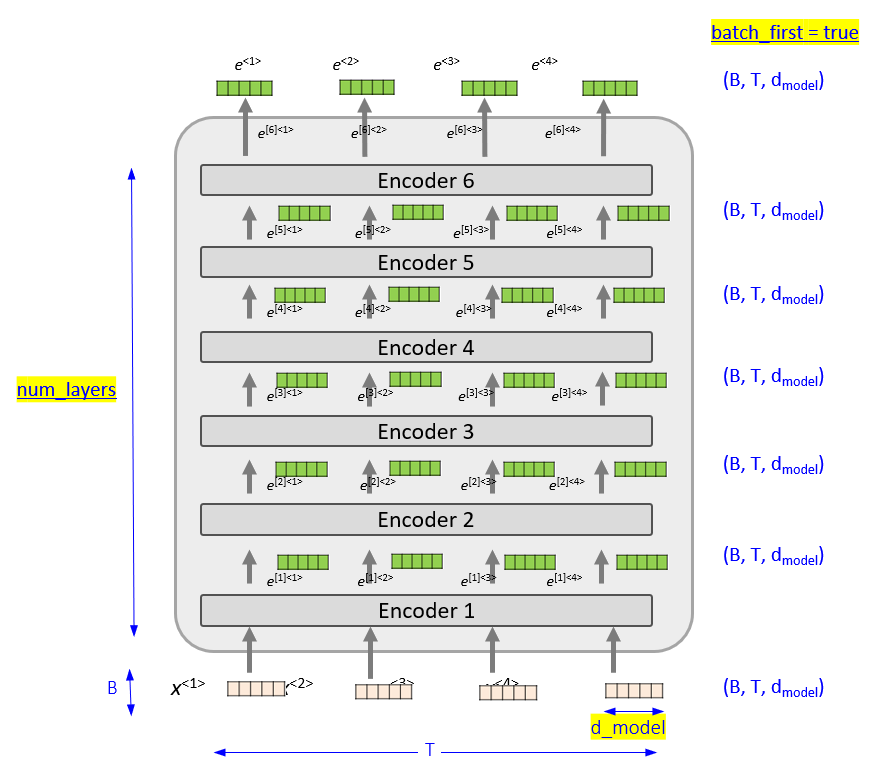

The following figure shows the block diagram for the encoder layer. Each layer contains a total of `n_head` heads. Each head consists of two modules:

1. Self-attention module

    Different from the origin transformer, PyTorch implementation replaces the *multi-head self-attention* layer with the **masked** version as shown below. This allows it the encoder be used for generative language modeling. 


2. Feed forward module

    This modules consists of two linear layer. The output feature length of the 1st linear layer is set to `dim_feedforward` while the 2nd linear layer is set to `d_model`.


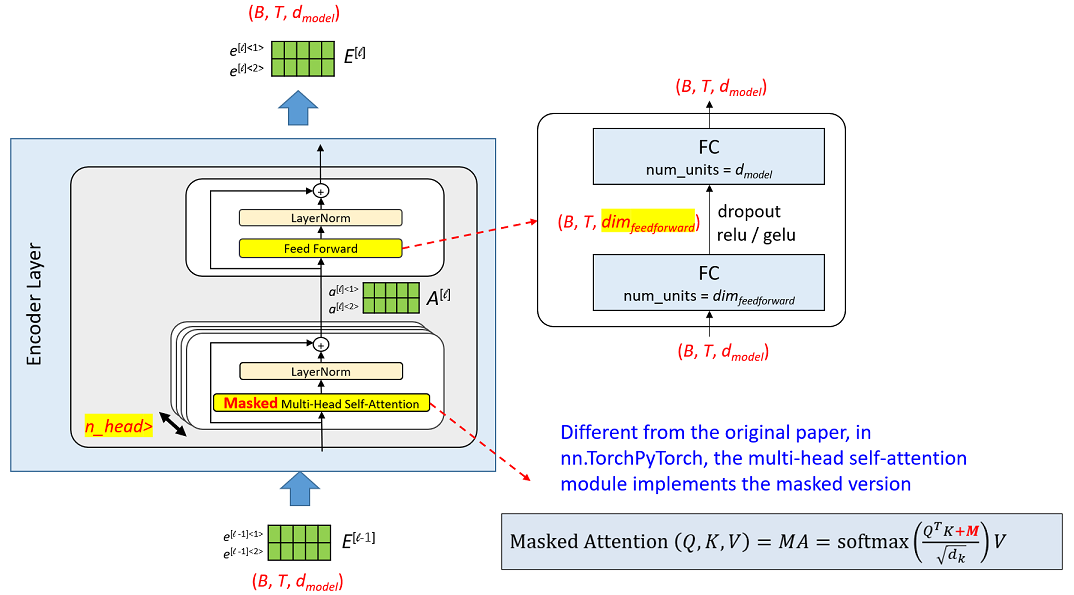

### Generating novel text

To generate novel text, we implement the method `generate`. Since the network is trained on a sequence of length `T` = `block_size`, when generating the text, we feed the most recent `block_size` characters into the network to generate the next character. Here are the steps:

1. Crop the most recent `block_size` characters in the generated text
2. The cropped text is fed to the generative model to generate the next character. The network output the `logit` value.
3. Convert the logit of the network to `probit` value by performing `softmax` operation.
4. Sample a character from the `probit` by using [`torch.multinorm`](https://pytorch.org/docs/stable/generated/torch.multinomial.html)
5. Append the sampled character to the end of the generated text.
6. Repeat steps 1-5 for `text_len` times



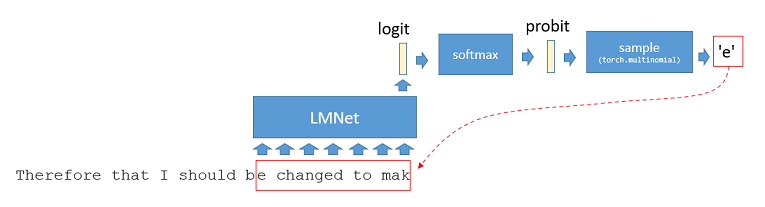

### Positional Embedding

The following `PositionalEncoding` module injects some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. To do so, we can use sine and cosine functions of different frequencies to embed the distance.

$PE_{(t, 2i)} = \sin (t / 10000^{2i/d_{model}})$
<br> $PE_{(t, 2i+1)} = \cos (t / 10000^{2i/d_{model}})$

where $t$ is the (time) index of the token in the input sequence and $i$ is the index of the embedding feature representing the token

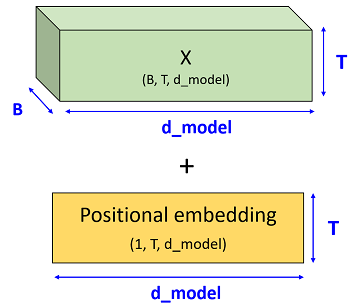

The following diagram shows how the position embedding looks like for different time steps.

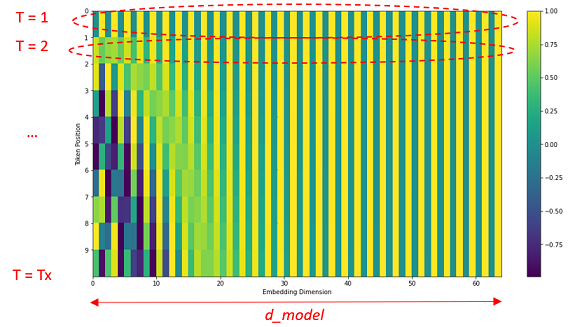

### Implement the Position Embedding

In [ ]:
class PositionEmbedding(nn.Module):

    def __init__(self, d_model: int, batch_first: bool = False, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first

        # Shape of position: (max_len, 1)
        position = torch.arange(max_len).unsqueeze(1)                                       
        
        # Shape of div_term: 1d tensor of shape (d_model/2, )
        div_term1 = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))  
        div_term2 = div_term1[:-1] if d_model % 2 == 1 else div_term1
        
        # shape of pe:  (max_len, 1, d_model)
        if self.batch_first:
            pe = torch.zeros(1, max_len, d_model)
            pe[0, :, 0::2] = torch.sin(position * div_term1)
            pe[0, :, 1::2] = torch.cos(position * div_term2)
            self.register_buffer('pe', pe)
        else:
            pe = torch.zeros(max_len, 1, d_model)
            pe[:, 0, 0::2] = torch.sin(position * div_term1)
            pe[:, 0, 1::2] = torch.cos(position * div_term2)
            self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        # Shape of self.pe: (T, 1, embedding_dim)
        # shape of x      : (T, B, embedding_dim)
        if self.batch_first:
            x = x + self.pe[:, :x.size(1), :]
        else:
            x = x + self.pe[:x.size(0)]
        return self.dropout(x)

Test the position embedding layer.

In [ ]:
batch_size = 4
seq_len    = 8
d_model    = 512

x = # ... your code here ...
print('Shape of x:', x.shape)

In [ ]:
pos_embedding = # ... your code here ...
xp = # ... your code here ... 
print('Shape of xp:', xp.shape)

### Implement the Language Model

In [ ]:
class LMNet(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, dim_feedforward=2048, num_layers=6, batch_first=True):
        super().__init__()

        # token embedding
        # ... your code here ...
        
        # positional embedding layer
        # ... your code here ...
        
        # create the encoder block
        # ... your code here ...
        
        # create the linear layer
        # ... your code here ...
    
    def forward(self, x, mask=None):             # (B,T)

        # convert each token into its embedding vetor
        # ... your code here ...
        
        # add position embedding to x
        # ... your code here ...

        # perform sequence model inference  
        # ... your code here ...
       
        # generate logits
        # ... your code here ...
        
        return x

    def generate(self, text_len, block_size):

        text = torch.zeros((1,1), dtype=torch.long).to(device)  # text token (B, T) where B is fixed to 1, T = 1 initially

        # repeat until the length of text = "text_len"
        for _ in range(text_len):  # (B, T)

            # crop text to the last block-size tokens
            text_cond = text[:, -block_size:]  # (B, T)

            # get the predictions
            seq_len = text_cond.shape[-1]
            mask = create_mask(seq_len)
            yhat  = self(text_cond, mask)  # logits: (B, T, C)
            
            # focus oly on the last time step
            yhat = yhat[:, -1, :] # becomes (B, C)

            # apply soft max to get probabilities
            probs = F.softmax(yhat, dim=-1)  # (B, C)

            # sample from distribution
            next_token = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # append sampled index to the running sequence
            text = torch.cat((text, next_token), dim=1) # (B, T+1)

            # print the sample
            print(itos[next_token.item()], end='')
            time.sleep(0.1)


Test the model without any masking

In [ ]:
d_model=512
nhead=8
dim_feedforward=2048
num_layers=6
vocab_size = len(vocab)
batch_first = True
batch_size=4
block_size=8

In [ ]:
model = LMNet(vocab_size, d_model, nhead, dim_feedforward, num_layers, batch_first).to(device)

In [ ]:
x, y = get_batch(batch_size, block_size)
x, y = x.to(device), y.to(device)

yhat = model(x)

print('Shape of x:    ', x.shape)
print('Shape of yhat: ', yhat.shape)

Test the model with masking

In [ ]:
def create_mask(Tx):
    # ... your code here ...
    return mask

In [ ]:
mask = create_mask(block_size)
print('Shape of mask:', mask.shape)

In [ ]:
yhat = model(x, mask)
print('Shape of yhat:', yhat.shape)

--------------------
# Train the model

In [ ]:
max_iters     = 5000
batch_size    = 128
block_size    = 256
lr            = 5e-4
max_iters     = 8000
show_interval = 200

d_model=256
nhead=4
dim_feedforward=512
num_layers=6
vocab_size = len(vocab)

Create the model

In [ ]:
model = LMNet(vocab_size, d_model, nhead, dim_feedforward, num_layers).to(device)

Create the optimizer

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

Train the model

To train the model, we use **teacher forcing** where the predicted output is simply the 1-shifted sequence of the input sequence. We shall train the network with sentence sequence of length `block_size`. Since the network is trained on sequences of length `block_size`, during inference, the generative model should use input sequence of similar length to get good results.

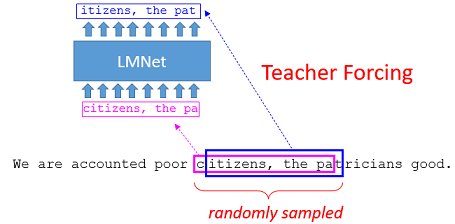

During training, the network is based on the many-to-many architecture. However, during inference (Figure at generating novel text), the network is based on many-to-one architecture.

In [ ]:
mask = create_mask(block_size)

for steps in range(max_iters):

    # sample a batch of data
    x, y = get_batch(batch_size, block_size)
        
    # forward propagation
    yhat = model(x, mask)

    # compute loss
    B, T, C = yhat.shape
    yhat = yhat.view(B*T, C)
    y = y.view(B*T)
    loss = F.cross_entropy(yhat, y)    

    # backpropagation
    loss.backward()
    optimizer.step()

    # reset the optimizer
    optimizer.zero_grad()

    # print the training loss
    if steps % show_interval == 0 or (steps+1)%max_iters == 0:
        print(f"Iter {steps}: train loss {loss:.4f}")

---
# Generate text

In [ ]:
model.generate(text_len=1000, block_size=block_size)

<center> --- End of practical --- </center>